<a href="https://colab.research.google.com/github/mariachurches/AprendizajeSupervisado/blob/main/Enunciado_C1_P1/Actividad_C1_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convocatoria 1 - Proyecto 1

In [118]:
#Librerias necesarias para el desarrollo del proyecto.
import cv2
import math
import numpy as np
from skimage import io
from tabulate import tabulate
from skimage import morphology
import matplotlib.pyplot as plt
from skimage.measure import label
from sklearn import preprocessing
from skimage.measure import regionprops
from scipy.ndimage.morphology import binary_fill_holes as bfh

#### 0) Cargar una de las imágenes histológicas

1.   Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
2.   Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
3. Visualizar la imagen

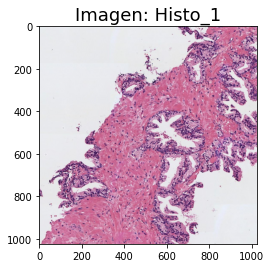

In [34]:
# Carga de datos.
img = io.imread("histo_1.jpg")

# Limpieza de datos: normalización.
img_nor = img/255

# Salida de resultados.
plt.imshow(img_nor)
plt.title('Imagen: Histo_1',fontsize=18)
plt.show()

Repetimos el procedimiento con la segunda imagen.

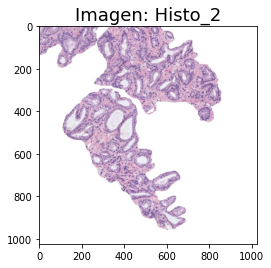

In [35]:
# Carga de datos.
img2 = io.imread("histo_2.jpg")

# Limpieza de datos: normalización.
img_nor2 = img2/255

# Salida de resultados.
plt.imshow(img_nor2)
plt.title('Imagen: Histo_2',fontsize=18)
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

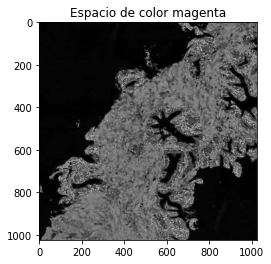

In [46]:
with np.errstate(invalid='ignore', divide='ignore'):
    K = 255 - np.max(img_nor, axis=2)
    C = (255-img_nor[...,0] - K)/(255-K)
    M = (255-img_nor[...,1] - K)/(255-K)
    Y = (255-img_nor[...,2] - K)/(255-K)

plt.imshow(M, cmap = 'gray')
plt.title('Espacio de color magenta')
plt.show()

Repetimos el procedimiento con la segunda imagen.

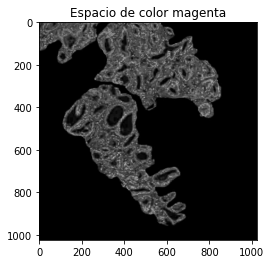

In [43]:
with np.errstate(invalid='ignore', divide='ignore'):
    K2 = 255 - np.max(img_nor2, axis=2)
    C2 = (255-img_nor2[...,0] - K2)/(255-K2)
    M2 = (255-img_nor2[...,1] - K2)/(255-K2)
    Y2 = (255-img_nor2[...,2] - K2)/(255-K2)

plt.imshow(M2, cmap = 'gray')
plt.title('Espacio de color magenta')
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

1.   Aplicar un filtro gaussiano de tamaño 5x5
2.   Utilizar el método de Otsu de manera que los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
3.   Visualizar la máscara resultante

Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8"


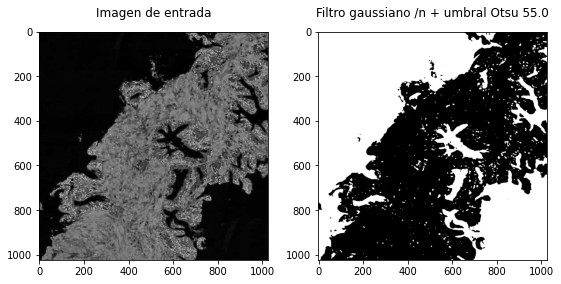

In [82]:
#Desnormalizamos para introducir la imagen en el formato adecuado
M_nor = M*255

#Aplicamos un filtro gaussiano
img_gaus = cv2.GaussianBlur(M_nor, (5,5), 0).astype('uint8')
t, mask  = cv2.threshold(img_gaus,0,255,cv2.THRESH_OTSU) 
mask = np.logical_not(mask).astype(int)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,8)
ax[0].imshow(M, cmap='gray'), ax[0].set_title('Imagen de entrada',pad=15.0)
ax[1].imshow(mask, cmap='gray'), ax[1].set_title('Filtro gaussiano + umbral Otsu ' + str(t), pad=15.0)

fig.tight_layout()
plt.show()

Repetimos el procedimiento con la segunda imagen.

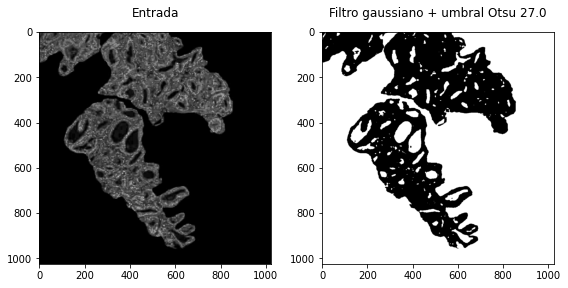

In [86]:
#Desnormalizamos para introducir la imagen en el formato adecuado
M_nor2 = M2*255

#Aplicamos un filtro gaussiano
img_gaus2 = cv2.GaussianBlur(M_nor2, (5,5), 0).astype('uint8')
t2, mask2  = cv2.threshold(img_gaus2,0,255,cv2.THRESH_OTSU) 
mask2 = np.logical_not(mask2).astype(int)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,8)
ax[0].imshow(M2, cmap='gray'), ax[0].set_title('Entrada',pad=15.0)
ax[1].imshow(mask2, cmap='gray'), ax[1].set_title('Filtro gaussiano + umbral Otsu ' + str(t2), pad=15.0)

fig.tight_layout()
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

1.   Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
2.   Visualizaer la máscara resultante

Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects



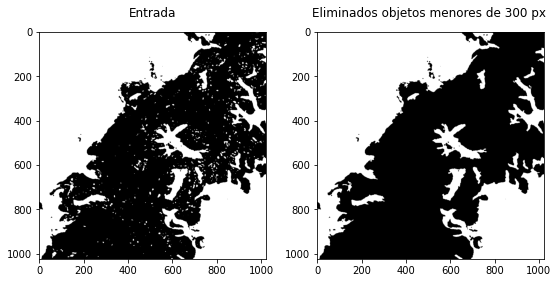

In [87]:
removed =  morphology.remove_small_objects(mask.astype(bool),300)
removed=removed.astype('uint8')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,8)
ax[0].imshow(mask, cmap='gray'), ax[0].set_title('Entrada',pad=15.0)
ax[1].imshow(removed, cmap='gray'), ax[1].set_title('Eliminados objetos menores de 300 px ', pad=15.0)

fig.tight_layout()
plt.show()

Repetimos el procedimiento con la segunda imagen.

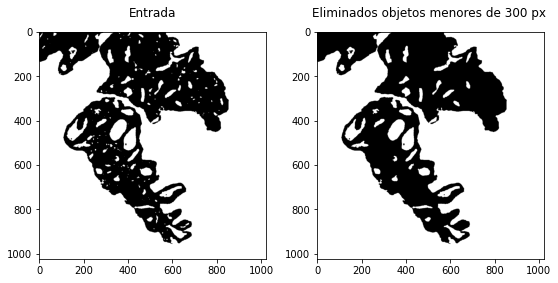

In [88]:
removed2 =  morphology.remove_small_objects(mask2.astype(bool),300)
removed2 = removed2.astype('uint8')

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,8)
ax[0].imshow(mask2, cmap='gray'), ax[0].set_title('Entrada',pad=15.0)
ax[1].imshow(removed2, cmap='gray'), ax[1].set_title('Eliminados objetos menores de 300 px ', pad=15.0)

fig.tight_layout()
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes


1.   Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos y el resto de la imagen negra.
2.   Visualizar la máscara resultante

Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.



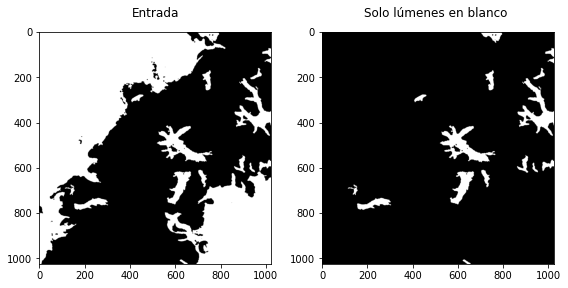

In [90]:
expansion = removed.copy()

h, w = removed.shape
ref = np.zeros((h+2, w+2), np.uint8)

# Fijar la semilla. En este caso en la esquina superior izquierda (posición 0,0) para rellenar a partir de ahí
cv2.floodFill(expansion, ref, (0,0), 0) # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición
cv2.floodFill(expansion, ref, (1000,1000), 0)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,8)
ax[0].imshow(removed, cmap='gray'), ax[0].set_title('Entrada',pad=15.0)
ax[1].imshow(expansion, cmap='gray'), ax[1].set_title('Solo lúmenes en blanco ', pad=15.0)

fig.tight_layout()
plt.show()

Repetimos el procedimiento con la segunda imagen.

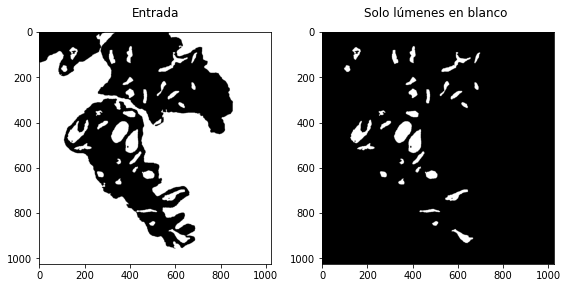

In [91]:
expansion2 = removed2.copy()

h2, w2 = removed2.shape
ref2 = np.zeros((h2+2, w2+2), np.uint8)

# Fijar la semilla. En este caso en la esquina superior izquierda (posición 0,0) para rellenar a partir de ahí
cv2.floodFill(expansion2, ref2, (0,0), 0) # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición
cv2.floodFill(expansion2, ref2, (1000,1000), 0)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,8)
ax[0].imshow(removed2, cmap='gray'), ax[0].set_title('Entrada',pad=15.0)
ax[1].imshow(expansion2, cmap='gray'), ax[1].set_title('Solo lúmenes en blanco ', pad=15.0)

fig.tight_layout()
plt.show()

#### 5) Rellenar los objetos de los lúmenes

1.   Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
2.   Visualizar la máscara resultante

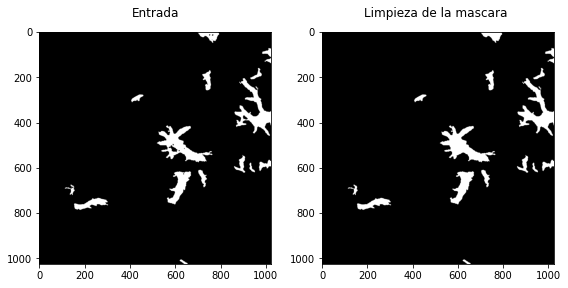

In [93]:
# Rellenar objetos (solo rellena si no están en contacto con el límite de la imagen)
filled_bordes = bfh(expansion)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,8)
ax[0].imshow(expansion, cmap='gray'), ax[0].set_title('Entrada',pad=15.0)
ax[1].imshow(filled_bordes, cmap='gray'), ax[1].set_title('Limpieza de la mascara ', pad=15.0)

fig.tight_layout()
plt.show()

Repetimos el procedimiento con la segunda imagen.

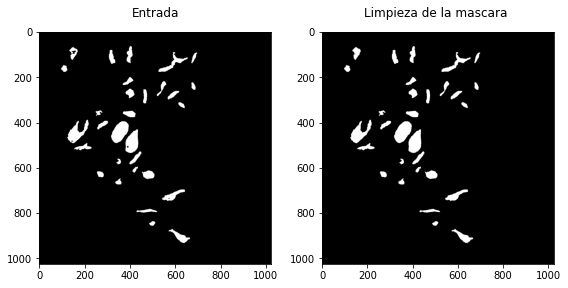

In [94]:
# Rellenar objetos (solo rellena si no están en contacto con el límite de la imagen)
filled_bordes2 = bfh(expansion2)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,8)
ax[0].imshow(expansion2, cmap='gray'), ax[0].set_title('Entrada',pad=15.0)
ax[1].imshow(filled_bordes2, cmap='gray'), ax[1].set_title('Limpieza de la mascara ', pad=15.0)

fig.tight_layout()
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

1.   Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB, utilizando los flags necesarios para que los contornos en verde sean perfectamente visibles
2.   Visualizar la imagen superpuesta

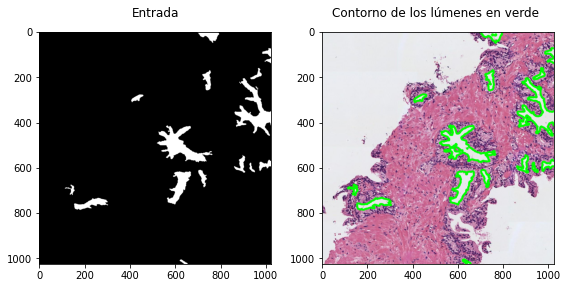

In [104]:
original = img.copy()
filled_bordes = filled_bordes.astype('uint8')

canny = cv2.Canny(expansion, 1/3, 1) 

conts,_ = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
final_conts = cv2.drawContours(original, conts, -1, (0,255,0), 7)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,8)
ax[0].imshow(filled_bordes, cmap='gray'), ax[0].set_title('Entrada', pad=15.0)
ax[1].imshow(final_conts), ax[1].set_title('Contorno de los lúmenes en verde ', pad=15.0)

fig.tight_layout()
plt.show()

Repetimos el procedimiento con la segunda imagen.

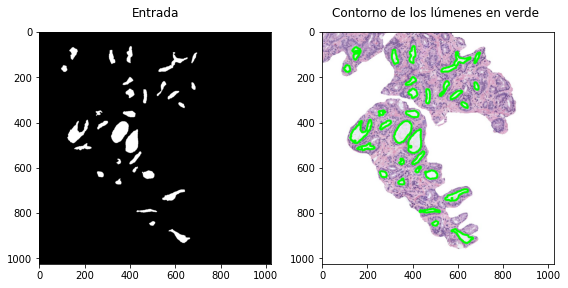

In [105]:
original2 = img2.copy()
filled_bordes2 = filled_bordes2.astype('uint8')

canny2 = cv2.Canny(expansion2, 1/3, 1) 

conts2,_ = cv2.findContours(canny2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
final_conts2 = cv2.drawContours(original2, conts2, -1, (0,255,0), 7)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,8)
ax[0].imshow(filled_bordes2, cmap='gray'), ax[0].set_title('Entrada', pad=15.0)
ax[1].imshow(final_conts2), ax[1].set_title('Contorno de los lúmenes en verde ', pad=15.0)

fig.tight_layout()
plt.show()

#### 7) Identificar y cropear el lumen más grande



1.   Determinar cuál es el lumen de mayor área
2.   Hacer un crop del mismo sobre la imagen original RGB
3.   Visualizar el lumen cropeado


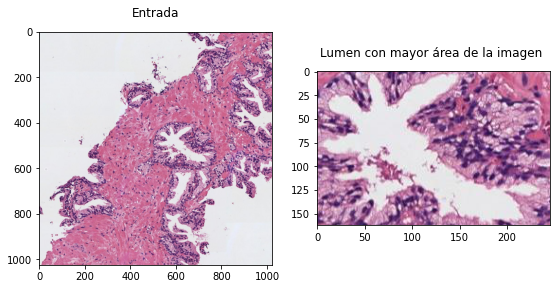

In [115]:
#Variables necesarias
highest_area=0
final_object 
points = []

lab, num = label(filled_bordes, return_num=True)

for i in range(1, num+1): 
  objeto = lab == i
  objeto = objeto.astype('uint8')
  # bbox
  prop = regionprops(objeto)

  if highest_area < np.round(prop[0].area):
    highest_area= np.round(prop[0].area)
    bbox = prop[0].bbox
    points = [bbox[0], bbox[1], bbox[2], bbox[3]]
    final_object = prop

biggest_lumen = img[points[0]:points[2],points[1]:points[3]]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,8)
ax[0].imshow(img, cmap='gray'), ax[0].set_title('Entrada', pad=15.0)
ax[1].imshow(biggest_lumen), ax[1].set_title('Lumen con mayor área de la imagen ', pad=15.0)

fig.tight_layout()
plt.show()

Repetimos el procedimiento con la segunda imagen.

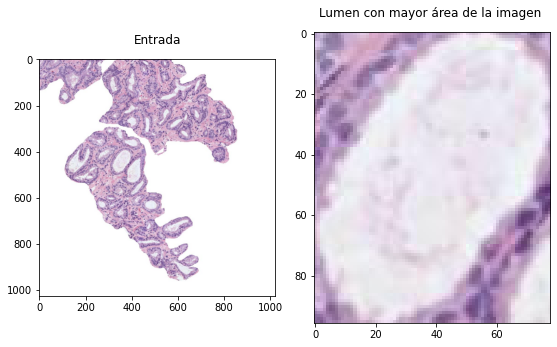

In [116]:
#Variables necesarias
highest_area=0
final_object
points = []

lab, num = label(filled_bordes2, return_num=True)

for i in range(1, num+1): 
  objeto = lab == i
  objeto = objeto.astype('uint8')
  # bbox
  prop = regionprops(objeto)

  if highest_area < np.round(prop[0].area):
    highest_area= np.round(prop[0].area)
    bbox = prop[0].bbox
    points = [bbox[0], bbox[1], bbox[2], bbox[3]]
    final_object2 = prop

biggest_lumen2 = img2[points[0]:points[2],points[1]:points[3]]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,8)
ax[0].imshow(img2, cmap='gray'), ax[0].set_title('Entrada', pad=15.0)
ax[1].imshow(biggest_lumen2), ax[1].set_title('Lumen con mayor área de la imagen ', pad=15.0)

fig.tight_layout()
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal

In [117]:
print(np.round(final_object2[0].area, 4))

4876


In [137]:


# Extraemos las característicias geométricas
headers = ['Características','Valores']
A,BB,CA,E,ED,EX,FD,MA,MiA,OR,P,S,CO = ['area'], ['bbox_area'], ['convex_area'], ['eccentricity'], ['equiv_diameter'], \
['extent'], ['feret_diameter'],['major_axis'], ['minor_axis'], ['orientation'], ['perimeter'], ['solidity'], ['compactness']

# Área
A.append(np.round(final_object[0].area, 4))
# Área de la bounding box
BB.append(np.round(final_object[0].bbox_area, 4))
# Área convexa
CA.append(np.round(final_object[0].convex_area, 4))
# Exentricidad
E.append(np.round(final_object[0].eccentricity, 4))
# Diámetro equivalente
ED.append(np.round(final_object[0].equivalent_diameter, 4))
# Extensión
EX.append(np.round(final_object[0].extent, 4))
# Diámetro Feret
FD.append(np.round(final_object[0].feret_diameter_max, 4))
# Longitud del eje mayor
MA.append(np.round(final_object[0].major_axis_length, 4))
# Longitud del eje menor
MiA.append(np.round(final_object[0].minor_axis_length, 4))
# Orientación
OR.append(np.round(final_object[0].orientation, 4))
# Perímetro
P.append(np.round(final_object[0].perimeter, 4))
# Solidez
S.append(np.round(final_object[0].solidity, 4))
# Compacidad
CO.append(np.round(4*math.pi*final_object[0].area/final_object[0].perimeter**2, 4))

my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
          tuple(FD),tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO)]

print("Lumen de mayor áren - imagen histo_1")
print(tabulate(my_data, headers=headers, tablefmt='fancy_grid'))

Lumen de mayor áren - imagen histo_1
╒═══════════════════╤════════════╕
│ Características   │    Valores │
╞═══════════════════╪════════════╡
│ area              │ 14078      │
├───────────────────┼────────────┤
│ bbox_area         │ 40098      │
├───────────────────┼────────────┤
│ convex_area       │ 29281      │
├───────────────────┼────────────┤
│ eccentricity      │     0.8477 │
├───────────────────┼────────────┤
│ equiv_diameter    │   133.883  │
├───────────────────┼────────────┤
│ extent            │     0.3511 │
├───────────────────┼────────────┤
│ feret_diameter    │   259.077  │
├───────────────────┼────────────┤
│ major_axis        │   238.582  │
├───────────────────┼────────────┤
│ minor_axis        │   126.558  │
├───────────────────┼────────────┤
│ orientation       │     1.0054 │
├───────────────────┼────────────┤
│ perimeter         │  1242.01   │
├───────────────────┼────────────┤
│ solidity          │     0.4808 │
├───────────────────┼────────────┤
│ compactness     

Repetimos el procedimiento con la segunda imagen.

In [138]:
# Extraemos las característicias geométricas
headers = ['Características','Valores']
A,BB,CA,E,ED,EX,FD,MA,MiA,OR,P,S,CO = ['area'], ['bbox_area'], ['convex_area'], ['eccentricity'], ['equiv_diameter'], \
['extent'], ['feret_diameter'],['major_axis'], ['minor_axis'], ['orientation'], ['perimeter'], ['solidity'], ['compactness']

# Área
A.append(np.round(final_object2[0].area, 4))
# Área de la bounding box
BB.append(np.round(final_object2[0].bbox_area, 4))
# Área convexa
CA.append(np.round(final_object2[0].convex_area, 4))
# Exentricidad
E.append(np.round(final_object2[0].eccentricity, 4))
# Diámetro equivalente
ED.append(np.round(final_object2[0].equivalent_diameter, 4))
# Extensión
EX.append(np.round(final_object2[0].extent, 4))
# Diámetro Feret
FD.append(np.round(final_object2[0].feret_diameter_max, 4))
# Longitud del eje mayor
MA.append(np.round(final_object2[0].major_axis_length, 4))
# Longitud del eje menor
MiA.append(np.round(final_object2[0].minor_axis_length, 4))
# Orientación
OR.append(np.round(final_object2[0].orientation, 4))
# Perímetro
P.append(np.round(final_object2[0].perimeter, 4))
# Solidez
S.append(np.round(final_object2[0].solidity, 4))
# Compacidad
CO.append(np.round(4*math.pi*final_object2[0].area/final_object2[0].perimeter**2, 4))

my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
          tuple(FD),tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO)]
          
print("Lumen de mayor áren - imagen histo_2")
print(tabulate(my_data, headers=headers, tablefmt='fancy_grid'))

Lumen de mayor áren - imagen histo_2
╒═══════════════════╤═══════════╕
│ Características   │   Valores │
╞═══════════════════╪═══════════╡
│ area              │ 4876      │
├───────────────────┼───────────┤
│ bbox_area         │ 7488      │
├───────────────────┼───────────┤
│ convex_area       │ 5009      │
├───────────────────┼───────────┤
│ eccentricity      │    0.8348 │
├───────────────────┼───────────┤
│ equiv_diameter    │   78.7929 │
├───────────────────┼───────────┤
│ extent            │    0.6512 │
├───────────────────┼───────────┤
│ feret_diameter    │  105.589  │
├───────────────────┼───────────┤
│ major_axis        │  106.418  │
├───────────────────┼───────────┤
│ minor_axis        │   58.5861 │
├───────────────────┼───────────┤
│ orientation       │   -0.5608 │
├───────────────────┼───────────┤
│ perimeter         │  280.978  │
├───────────────────┼───────────┤
│ solidity          │    0.9734 │
├───────────────────┼───────────┤
│ compactness       │    0.7761 │
╘══════════